# 深度学习 | 手把手教你实现信用卡欺诈侦测建模
https://www.sohu.com/a/156447443_572440

In [121]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense
from keras.models import Model,load_model

from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=14,8

RANDOM_SEED =42
LABELS =['Normal','Fraud']

help(pickle)

help(sns)

In [97]:
df = pd.read_csv('../data/creditcard.csv')#creditcard.csv数据集在上一层文件夹的data文件夹里

In [98]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [99]:
df.shape

(284807, 31)

In [100]:
df.isnull().values.any()#结果是False说明没有缺失值

False

Text(0,0.5,'Frequency')

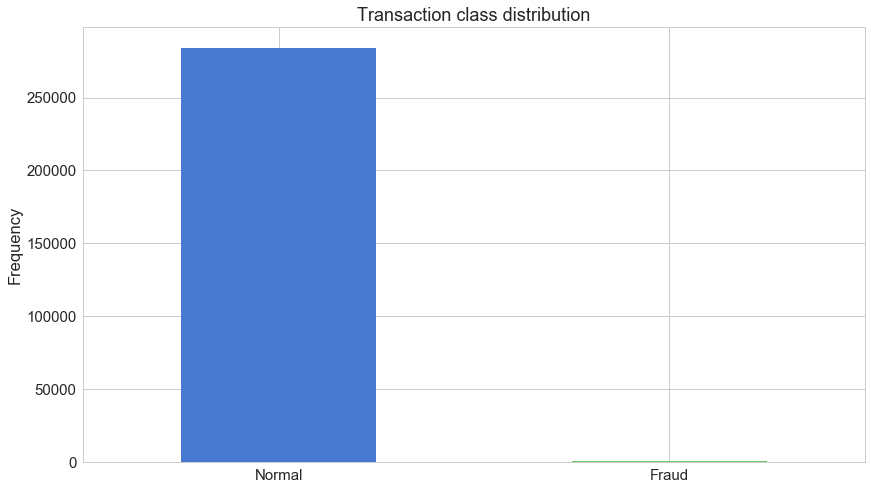

In [101]:
count_classes = pd.value_counts(df['Class'],sort = True)
count_classes.plot(kind = 'bar',rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2),LABELS)
plt.ylabel("Class")
plt.ylabel("Frequency")

In [102]:
frauds = df[df.Class==1]
normal = df[df.Class==0]


In [103]:
frauds.shape


(492, 31)

In [104]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes

In [105]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [106]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

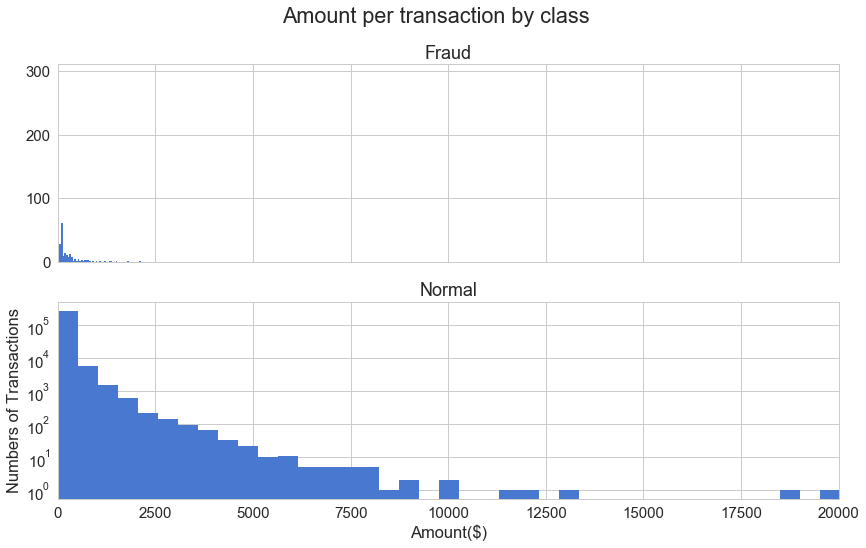

In [107]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle("Amount per transaction by class")

bins = 50

ax1.hist(frauds.Amount,bins = bins)
ax1.set_title("Fraud")

ax2.hist(normal.Amount,bins=bins)
ax2.set_title("Normal")

plt.xlabel("Amount($)")
plt.ylabel('Numbers of Transactions')
plt.xlim((0,20000))
plt.yscale("log")
plt.show();

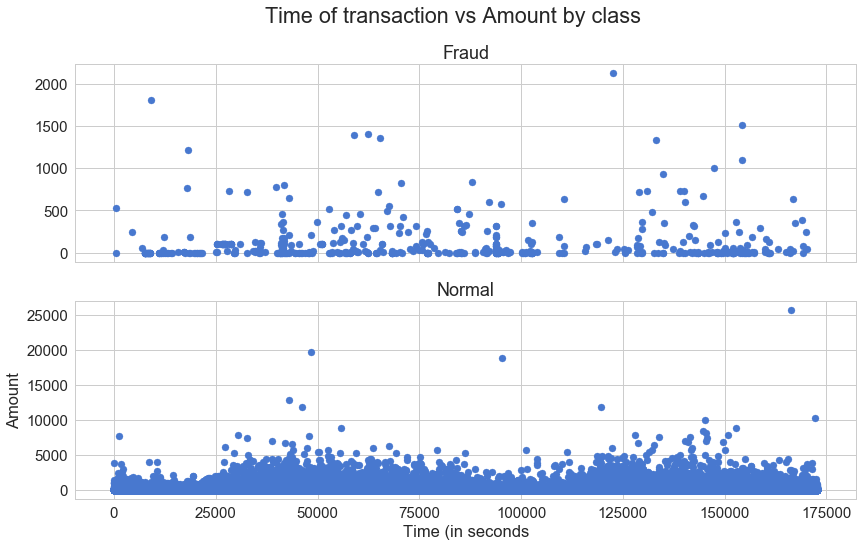

In [108]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle("Time of transaction vs Amount by class")

ax1.scatter(frauds.Time,frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time,normal.Amount)
ax2.set_title("Normal")

plt.xlabel("Time (in seconds")
plt.ylabel('Amount')
plt.show()

In [109]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'],axis=1)
data['Amount'] =StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

在拆分数据集中我们也drop掉了class变量，可以看出自动编码器算法Autoencoder实际上是一种特殊的非监督类算法，或者是半监督类算法。

In [94]:
X_train,X_test = train_test_split(data,test_size=0.2,random_state = RANDOM_SEED)
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'],axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'],axis=1)

X_train=X_train.values
X_test=X_test.values

In [112]:
X_train.shape

(227451, 29)

In [113]:
X_test.shape

(56962, 29)

自动编码器分别建立4个完全连接Dense层，分别为14，7，7，29个神经元。前两层用于编码器encode，最后两层用于解码器decode。训练期间将使用L1正规化

In [114]:
input_dim = X_train.shape[1]
encoding_dim = 14

help(Input)

help(Dense)

help(regularizers)

# 构建深度学习自动编码器

In [115]:
input_layer = Input(shape=(input_dim,))

encoder = Dense(encoding_dim,activation="tanh" , activity_regularizer=regularizers.l1(10e-5))(input_layer)
#注意，regularizers后面是字母‘l’和数字‘1’
encoder = Dense(int(encoding_dim/2),activation='relu')(encoder)

decoder = Dense(int(encoding_dim/2),activation='tanh')(encoder)

decoder = Dense(input_dim,activation='relu')(decoder)

autoencoder = Model(inputs=input_layer,outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 14)                420       
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_29 (Dense)             (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train,X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test,X_test),
                          verbose=1,
                          callbacks=[checkpointer,tensorboard]).history


In [116]:
X_test.shape

(56962, 29)

In [117]:
nb_epoch = 100
batch_size = 32
 
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
 
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
 
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.8134 - acc: 0.5806 - val_loss: 0.7900 - val_acc: 0.6456
Epoch 2/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7509 - acc: 0.6469 - val_loss: 0.7771 - val_acc: 0.6494
Epoch 3/100
227451/227451 [==============================] - 12s 54us/step - loss: 0.7397 - acc: 0.6532 - val_loss: 0.7667 - val_acc: 0.6485
Epoch 4/100
227451/227451 [==============================] - 13s 56us/step - loss: 0.7338 - acc: 0.6555 - val_loss: 0.7651 - val_acc: 0.6529
Epoch 5/100
227451/227451 [==============================] - 12s 55us/step - loss: 0.7303 - acc: 0.6596 - val_loss: 0.7626 - val_acc: 0.6580
Epoch 6/100
227451/227451 [==============================] - 13s 57us/step - loss: 0.7283 - acc: 0.6616 - val_loss: 0.7604 - val_acc: 0.6608
Epoch 7/100
227451/227451 [==============================] - 13s 55us/step - loss: 0.7273 - acc: 0.6638

227451/227451 [==============================] - 11s 49us/step - loss: 0.7166 - acc: 0.6704 - val_loss: 0.7532 - val_acc: 0.6635
Epoch 59/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7166 - acc: 0.6702 - val_loss: 0.7541 - val_acc: 0.6719
Epoch 60/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7159 - acc: 0.6700 - val_loss: 0.7523 - val_acc: 0.6630
Epoch 61/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7168 - acc: 0.6700 - val_loss: 0.7497 - val_acc: 0.6717
Epoch 62/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7161 - acc: 0.6704 - val_loss: 0.7507 - val_acc: 0.6760
Epoch 63/100
227451/227451 [==============================] - 12s 52us/step - loss: 0.7156 - acc: 0.6710 - val_loss: 0.7525 - val_acc: 0.6767
Epoch 64/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7165 - acc: 0.6704 - val_loss: 0.7507 - val_acc: 0.6706
Epoch 65/100
227451

In [122]:
autoencoder = load_model("model.h5")

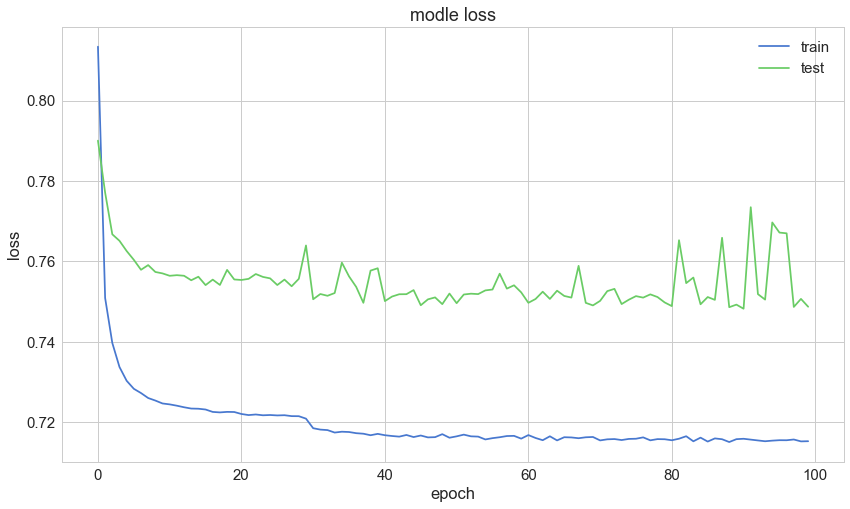

In [127]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('modle loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right');

In [128]:
predictions = autoencoder.predict(X_test)

In [130]:
mse = np.mean(np.power(X_test - predictions,2),axis=1)
error_df = pd.DataFrame({'reconstruction_error':mse,'true_class':y_test})             

In [131]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.739421,0.001720
std,3.427078,0.041443
min,0.037626,0.000000
25%,0.245470,0.000000
50%,0.400760,0.000000
75%,0.638953,0.000000
max,274.798686,1.000000


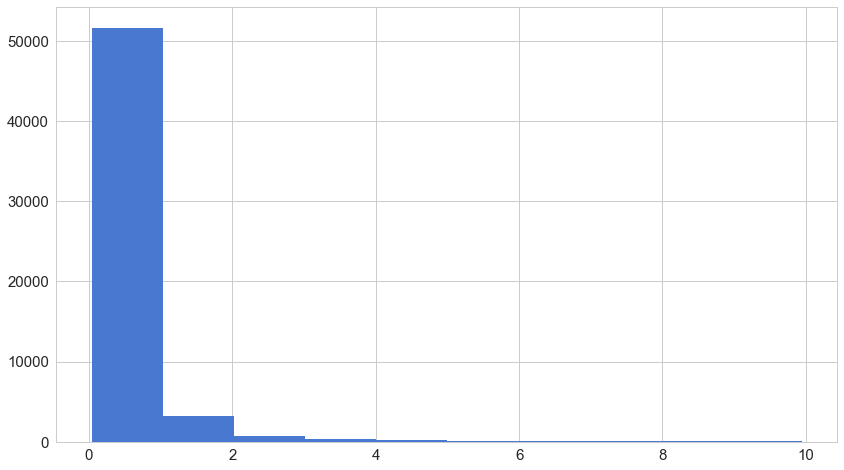

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0)&(error_df['reconstruction_error']<10)]
_ = ax.hist(normal_error_df.reconstruction_error.values,bins=10)
                            

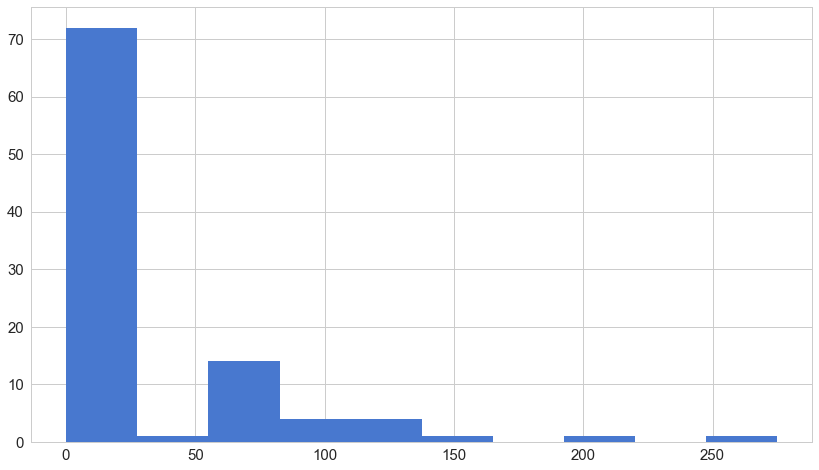

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class']==1]
_ = ax.hist(fraud_error_df.reconstruction_error.values,bins=10)

In [135]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support)

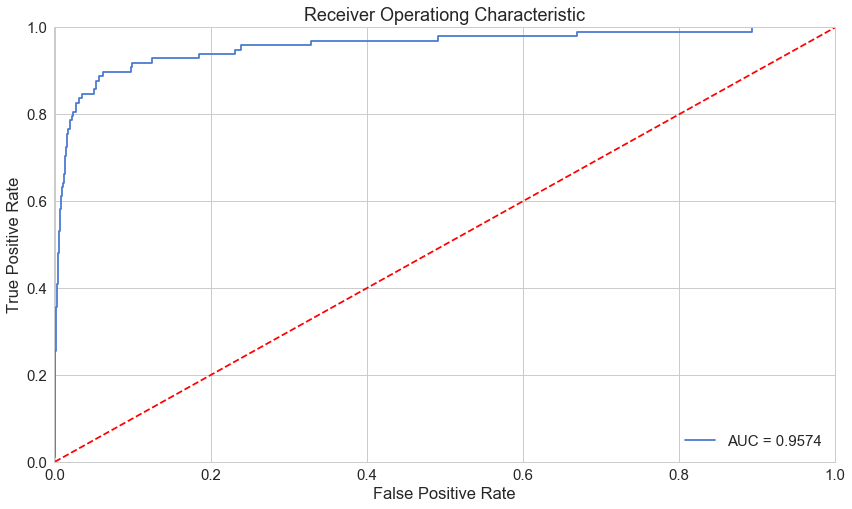

In [136]:
fpr, tpr, thresholds = roc_curve(error_df.true_class,error_df.reconstruction_error)
roc_auc = auc(fpr,tpr)

plt.title("Receiver Operationg Characteristic")
plt.plot(fpr, tpr, label='AUC = %0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()